Loading data: 100%|██████████| 101/101 [00:00<00:00, 261.53it/s]


✅ Using 389 daily returns for simulation.
✅ 1-Day 95% VaR: $1,915,160.77
✅ 30-Day 95% VaR: $9,135,498.07
✅ 90-Day 95% VaR: $14,391,988.54
✅ 250-Day 95% VaR: $21,087,870.84


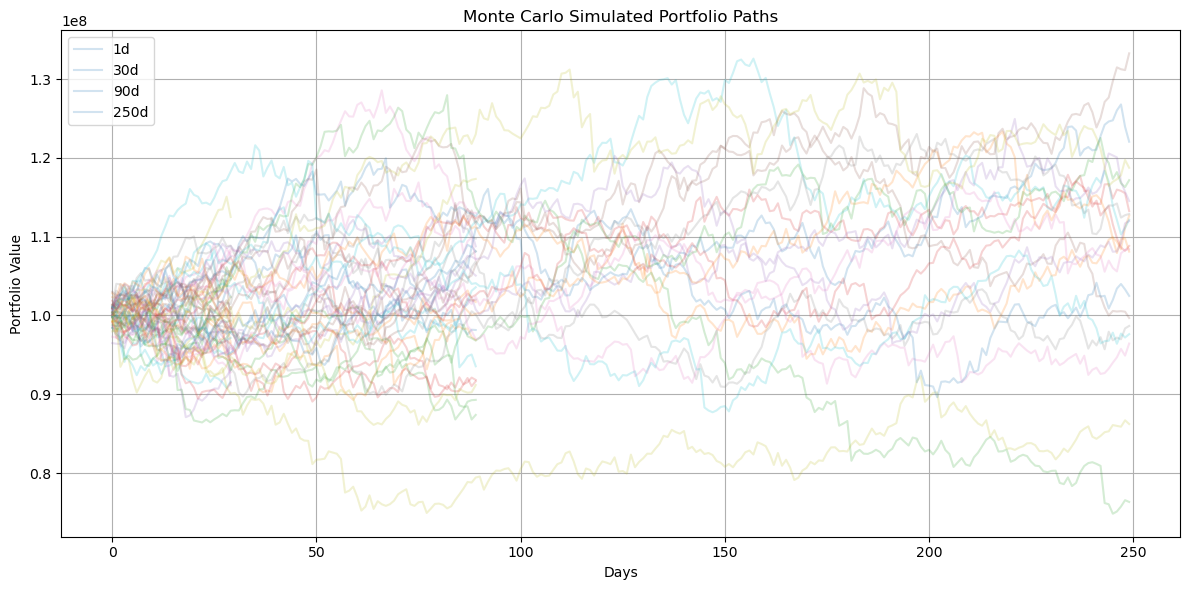

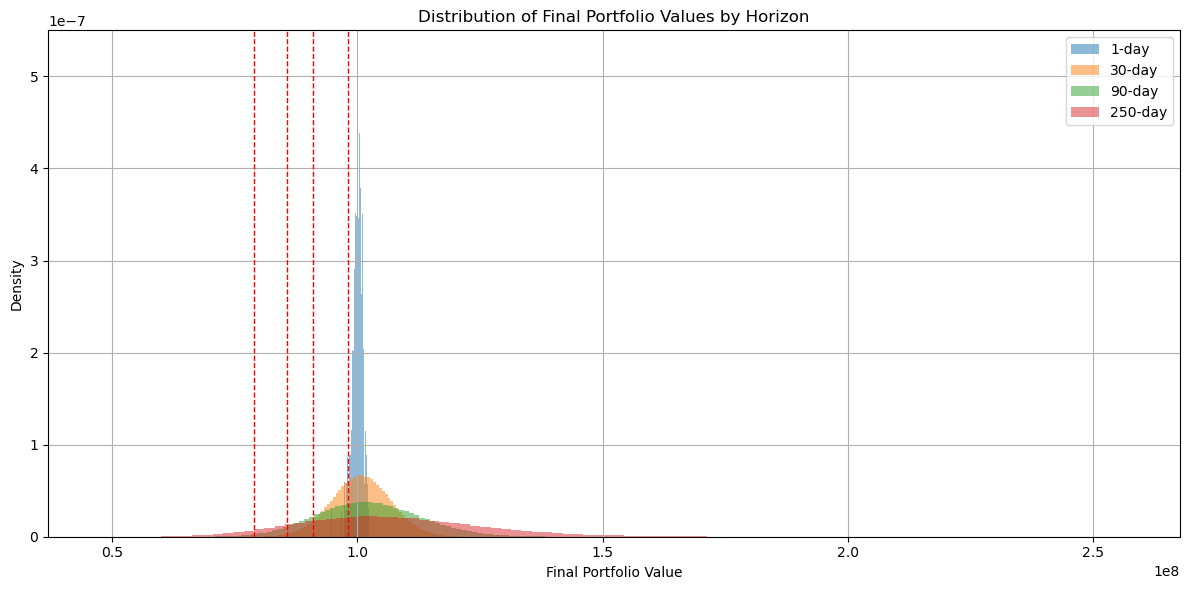

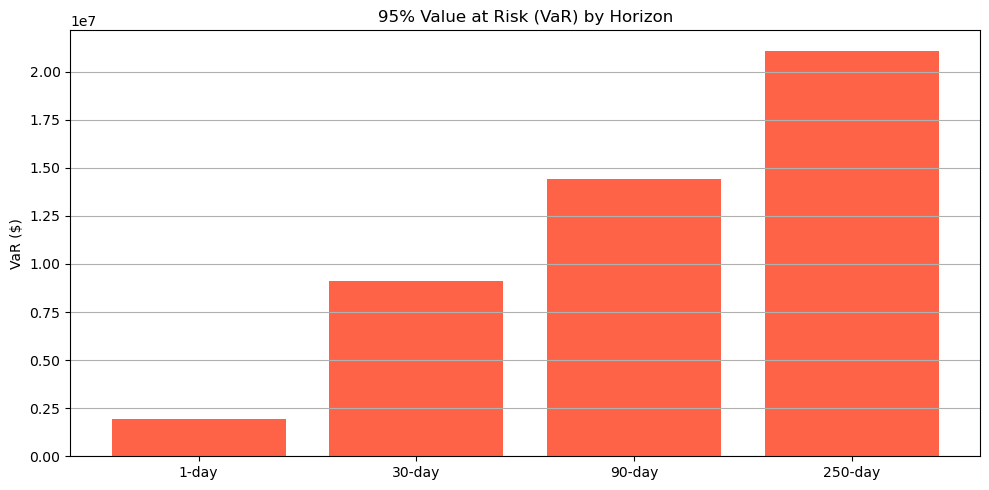

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# === Parameters ===
initial_portfolio_value = 100_000_000
n_simulations = 1_000_000
confidence_level = 0.05
horizons = [1, 30, 90, 250]  # Days to simulate

# === Load Data ===
tickers_df = pd.read_csv('nasdaq_tickers.csv')
tickers = tickers_df['ticker'].tolist()
data_path = 'stock_data/eod'

price_data = {}
for ticker in tqdm(tickers, desc="Loading data"):
    try:
        df = pd.read_csv(f"{data_path}/{ticker}.csv", parse_dates=['date'], index_col='date')
        if 'close' in df.columns:
            price_data[ticker] = df['close']
    except Exception as e:
        print(f"Skipping {ticker}: {e}")

# Combine and clean
df_prices = pd.concat(price_data, axis=1).dropna()
log_returns = np.log(df_prices / df_prices.shift(1)).dropna()

# Portfolio returns (equal weights)
weights = np.array([1 / len(log_returns.columns)] * len(log_returns.columns))
portfolio_returns = log_returns.dot(weights)

print(f"✅ Using {len(portfolio_returns)} daily returns for simulation.")

# === Run Monte Carlo for each horizon ===
simulated_paths = {}
histograms = {}
var_results = {}

for horizon in horizons:
    sampled_returns = np.random.choice(portfolio_returns.values, size=(n_simulations, horizon))
    simulations = np.exp(np.cumsum(sampled_returns, axis=1)) * initial_portfolio_value
    final_values = simulations[:, -1]
    var = initial_portfolio_value - np.percentile(final_values, 100 * confidence_level)

    simulated_paths[horizon] = simulations
    histograms[horizon] = final_values
    var_results[horizon] = var

    print(f"✅ {horizon}-Day 95% VaR: ${var:,.2f}")

# === Plot 1: Simulated Price Paths ===
plt.figure(figsize=(12, 6))
for horizon in horizons:
    for i in range(20):
        plt.plot(simulated_paths[horizon][i], alpha=0.2, label=f"{horizon}d" if i == 0 else "")
plt.title("Monte Carlo Simulated Portfolio Paths")
plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot 2: Histograms of Final Portfolio Values ===
plt.figure(figsize=(12, 6))
for horizon in horizons:
    plt.hist(histograms[horizon], bins=100, alpha=0.5, label=f'{horizon}-day', density=True)
    plt.axvline(np.percentile(histograms[horizon], 100 * confidence_level), linestyle='--', linewidth=1, color='red')
plt.title("Distribution of Final Portfolio Values by Horizon")
plt.xlabel("Final Portfolio Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot 3: Bar Chart of VaR ===
plt.figure(figsize=(10, 5))
plt.bar([f"{h}-day" for h in horizons], [var_results[h] for h in horizons], color='tomato')
plt.title("95% Value at Risk (VaR) by Horizon")
plt.ylabel("VaR ($)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()
